In [1]:
from bayes_opt import BayesianOptimization, UtilityFunction
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from unidecode import unidecode

import json
import matplotlib
import numpy as np
import pandas as pd
import re
import xgboost as xgb

tqdm.pandas()

In [2]:
PATH = "../data/twibot/{}.json"
DATE_REF = "2022-06-01"

In [3]:
def extract_following(neighbors: dict):
    if neighbors is None:
        return np.nan
    return neighbors.get('following', np.nan)

def extract_followers(neighbors: dict):
    if neighbors is None:
        return np.nan
    return neighbors.get('follower', np.nan) 
    

def build_df(filename: str):
    with open(PATH.format(filename)) as f:
        data = json.load(f)
        
    df = pd.DataFrame.from_dict(data)
    df_profile = pd.DataFrame.from_dict(df['profile'].values.tolist())
    df = pd.concat([ df, df_profile ], axis=1)
    # df['following'] = df['neighbor'].apply(extract_following)
    # df['followers'] = df['neighbor'].apply(extract_followers)
    # df = df.drop([ 'ID', 'id_str', 'profile', 'neighbor' ], axis=1)
    
    df = df[[
        'id', 'screen_name', 'location', 'followers_count',
        'friends_count', 'statuses_count', 'created_at',
        'tweet', 'label'
    ]]

    df['id'] = df['id'].astype(str).str.strip()
    df['screen_name'] = df['screen_name'].astype(str).str.strip()
    df['location'] = df['location'].astype(str).str.strip()
    df['followers_count'] = df['followers_count'].astype(int)
    df['friends_count'] = df['friends_count'].astype(int)
    df['statuses_count'] = df['statuses_count'].astype(int)
    
    df.loc[df['location'] == "", 'location'] = np.nan
    le = LabelEncoder()
    le.fit(df['location'].unique())
    df['location_enc'] = le.transform(df['location'])
    
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['created_at_year'] = df['created_at'].dt.year
    df['created_at_month'] = df['created_at'].dt.month
    df['created_at_day'] = df['created_at'].dt.day
    df['created_at_date'] = (pd.Timestamp(DATE_REF).date() - df['created_at'].dt.date).dt.days.astype(int)
    df['created_at_hour'] = df['created_at'].dt.hour * 60 + df['created_at'].dt.minute
    df = df.drop('created_at', axis=1)
    
    df = df.explode('tweet').reset_index(drop=True)
    df['tweet'] = df['tweet'].astype(str).str.strip()
    df['label'] = df['label'].astype(int)
    
    print(df.shape)
    return df

In [4]:
df_train = build_df('train')
df_test = build_df('test')

(1398465, 14)
(199863, 14)


# Training data exploration

In [5]:
df_train_users = df_train.drop([ 'tweet', 'location', 'screen_name', 'id' ], axis=1).drop_duplicates()
df_train_users = df_train_users.reset_index(drop=True)
print(df_train_users.shape)
df_train_users.head()

(8278, 10)


,followers_count,friends_count,statuses_count,label,location_enc,created_at_year,created_at_month,created_at_day,created_at_date,created_at_hour
0,15349596,692,9798,0,1872,2008,11,18,4427,627
1,0,44,0,1,3130,2020,8,23,131,455
2,762839,475,5518,0,876,2008,11,27,4418,1127
3,327587,4801,192876,0,2440,2008,8,6,4531,912
4,13324,647,103,1,1185,2013,8,10,2701,205


In [6]:
df_train_users['label'].mean()

0.5612466779415318

In [7]:
def plot_distrib(colname: str):
    print(colname)
    # Humans
    df_train_users[df_train_users['label'] == 0][colname].plot.hist(alpha=0.5, bins=100, logy=True)
    # Bots
    df_train_users[df_train_users['label'] == 1][colname].plot.hist(alpha=0.5, bins=100, logy=True)
    plt.show()

followers_count


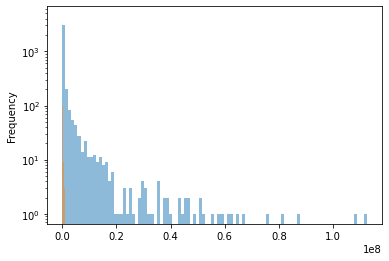

friends_count


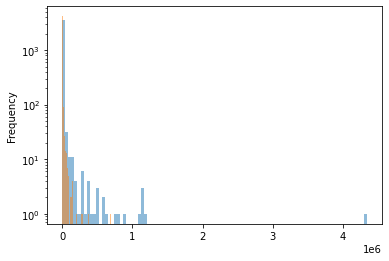

statuses_count


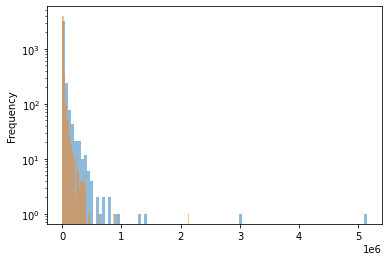

In [8]:
plot_distrib('followers_count')
plot_distrib('friends_count')
plot_distrib('statuses_count')

In [9]:
cmap = matplotlib.colors.ListedColormap(['blue', 'red'])

def plot_scatter(colname_1: str, colname_2: str, **kwargs):
    df_train_users.plot.scatter(colname_1, 
                                colname_2,
                                c='label', 
                                alpha=0.05,
                                cmap=cmap,
                                loglog=True,
                                **kwargs)
    plt.show()

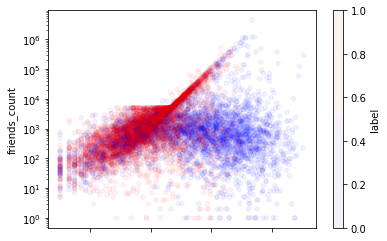

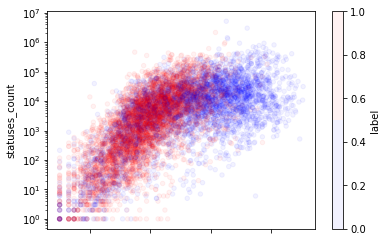

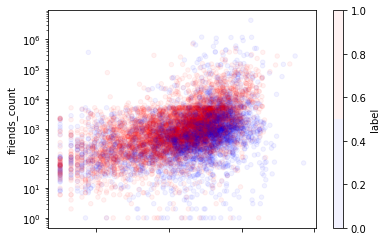

In [10]:
plot_scatter('followers_count', 'friends_count')
plot_scatter('followers_count', 'statuses_count')
plot_scatter('statuses_count', 'friends_count')

# Trying detection w/o tweets

In [11]:
X_train_users = df_train_users.drop('label', axis=1)
y_train_users = df_train_users['label']
X_train_users.head()

,followers_count,friends_count,statuses_count,location_enc,created_at_year,created_at_month,created_at_day,created_at_date,created_at_hour
0,15349596,692,9798,1872,2008,11,18,4427,627
1,0,44,0,3130,2020,8,23,131,455
2,762839,475,5518,876,2008,11,27,4418,1127
3,327587,4801,192876,2440,2008,8,6,4531,912
4,13324,647,103,1185,2013,8,10,2701,205


In [12]:
df_test_users = df_test.drop([ 'tweet', 'location', 'screen_name', 'id' ], axis=1).drop_duplicates()
df_test_users = df_test_users.reset_index(drop=True)
print(df_test_users.shape)

X_test_users = df_test_users.drop('label', axis=1)
y_test_users = df_test_users['label']

(1183, 10)


In [13]:
def format_kwargs(kwargs: dict):
    
    int_cols = [ 'n_estimators', 'maxdepth' ]
    for int_col in int_cols:
        if int_col in kwargs:
            kwargs[int_col] = int(kwargs[int_col])
            
    kwargs.update({
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'early_stopping_rounds': 10,
        'evalset': [( X_test_users, y_test_users )]
    })
    return kwargs


def training(**kwargs):
    clf = xgb.XGBClassifier(**format_kwargs(kwargs))

    clf.fit(X_train_users, y_train_users)
    y_pred_users = clf.predict(X_test_users)
    return roc_auc_score(y_test_users, y_pred_users)

pbounds = {
    'n_estimators': (50, 300),
    'maxdepth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.5, 1)
}
optimizer = BayesianOptimization(f=training,
                                 pbounds=pbounds, 
                                 verbose=2,
                                 random_state=4)
optimizer.maximize(init_points=5, n_iter=30)

best_params = format_kwargs(optimizer.max['params'])
print(f"Best result: {best_params}; AUC = {optimizer.max['target']}")

|   iter    |  target   | learni... | maxdepth  | n_esti... | subsample |
-------------------------------------------------------------------------
|  1        |  0.716    |  0.2904   |  6.831    |  293.2    |  0.8574   |
|  2        |  0.7319   |  0.2123   |  4.513    |  294.1    |  0.5031   |
|  3        |  0.7506   |  0.08336  |  6.044    |  244.8    |  0.5988   |
|  4        |  0.7379   |  0.2603   |  9.884    |  90.96    |  0.7987   |
|  5        |  0.7504   |  0.01261  |  5.706    |  61.04    |  0.9783   |
|  6        |  0.7466   |  0.05912  |  3.803    |  246.2    |  0.681    |
|  7        |  0.7198   |  0.222    |  8.041    |  248.0    |  0.5436   |
|  8        |  0.7461   |  0.05225  |  4.195    |  244.0    |  0.7472   |
|  9        |  0.7469   |  0.106    |  4.864    |  63.55    |  0.9021   |
|  10       |  0.7345   |  0.3      |  3.0      |  60.49    |  0.5      |
|  11       |  0.7511   |  0.01     |  7.725    |  62.5     |  1.0      |
|  12       |  0.7502   |  0.01     | 

c:\users\flo\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


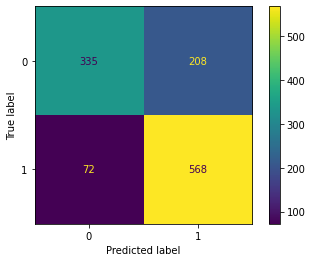

In [14]:
clf_users = xgb.XGBClassifier(**best_params)
clf_users.fit(X_train_users, y_train_users)
plot_confusion_matrix(clf_users, X_test_users, y_test_users)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

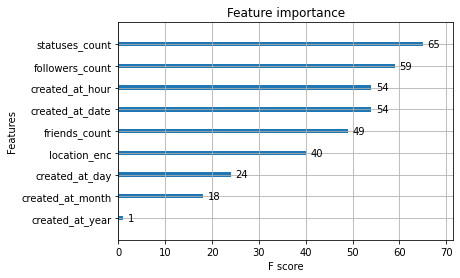

In [15]:
xgb.plot_importance(clf_users)

> __Some feature engineering__

In [16]:
X_train_users['avg_daily_followers'] = np.round(X_train_users['followers_count'] / X_train_users['created_at_date'], 3)
X_train_users['avg_daily_friends'] = np.round(X_train_users['friends_count'] / X_train_users['created_at_date'], 3)
X_train_users['avg_daily_statuses'] = np.round(X_train_users['statuses_count'] / X_train_users['created_at_date'], 3)

X_test_users['avg_daily_followers'] = np.round(X_test_users['followers_count'] / X_test_users['created_at_date'], 3)
X_test_users['avg_daily_friends'] = np.round(X_test_users['friends_count'] / X_test_users['created_at_date'], 3)
X_test_users['avg_daily_statuses'] = np.round(X_test_users['statuses_count'] / X_test_users['created_at_date'], 3)

In [17]:
pbounds = {
    'n_estimators': (50, 300),
    'maxdepth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.5, 1)
}
optimizer = BayesianOptimization(f=training,
                                 pbounds=pbounds, 
                                 verbose=2,
                                 random_state=4)
optimizer.maximize(init_points=5, n_iter=30)

best_params = format_kwargs(optimizer.max['params'])
print(f"Best result: {best_params}; AUC = {optimizer.max['target']}")

|   iter    |  target   | learni... | maxdepth  | n_esti... | subsample |
-------------------------------------------------------------------------
|  1        |  0.7335   |  0.2904   |  6.831    |  293.2    |  0.8574   |
|  2        |  0.727    |  0.2123   |  4.513    |  294.1    |  0.5031   |
|  3        |  0.7458   |  0.08336  |  6.044    |  244.8    |  0.5988   |
|  4        |  0.7331   |  0.2603   |  9.884    |  90.96    |  0.7987   |
|  5        |  0.7466   |  0.01261  |  5.706    |  61.04    |  0.9783   |
|  6        |  0.7418   |  0.1322   |  3.484    |  63.97    |  0.6198   |
|  7        |  0.7466   |  0.01     |  10.0     |  62.25    |  1.0      |
|  8        |  0.7456   |  0.296    |  9.421    |  55.62    |  0.8186   |
|  9        |  0.7232   |  0.1887   |  7.012    |  236.8    |  0.5459   |
|  10       |  0.7486   |  0.038    |  5.272    |  250.8    |  0.5892   |
|  11       |  0.7477   |  0.01305  |  9.982    |  256.6    |  0.9061   |
|  12       |  0.7299   |  0.3      | 

c:\users\flo\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


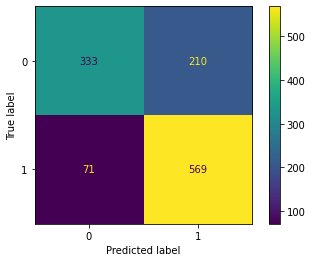

In [18]:
clf_users_fe = xgb.XGBClassifier(**best_params)
clf_users_fe.fit(X_train_users, y_train_users)
plot_confusion_matrix(clf_users_fe, X_test_users, y_test_users)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

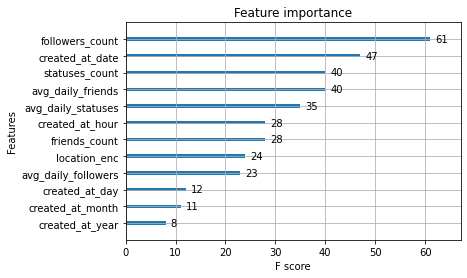

In [19]:
xgb.plot_importance(clf_users_fe)

# Adding NLP on tweets

> __Couldn't extract emojis (takes way too much time)__

In [5]:
def extract_retweet(text: str):
    res = re.match(r'RT @(\w*): \.?', text)
    if res:
        text = text[res.span(0)[1]:]
        return text, True, res.group(1)
    return text, False, np.nan

def extract_hashtags(text: str):
    hashtags = [ hashtag[1:] for hashtag in re.findall(r"#\w*\b", text) ]
    text = re.sub(r"(?<=#)(?=\w*\b)", " ", text)
    return text, hashtags

def extract_mentions(text: str):
    mentions = [ mention[1:] for mention in re.findall(r"@\w*\b", text) ]
    text = re.sub(r"(?<=@)\w*\b", " ", text)
    return text, mentions

def clean_text(text: str):
    text_cleaned = unidecode(text)
    nb_emojis = len(text) - len(text_cleaned)
    text_cleaned = re.sub(r'\s+', ' ', text_cleaned)
    text_cleaned = text_cleaned.replace('\n', ' ')
    text_cleaned = " ".join(text_cleaned.split())[:-1]
    return text_cleaned, nb_emojis


def extract_artefacts(text: str):
    text, is_rt, retweet = extract_retweet(text)
    text, hashtags = extract_hashtags(text)
    text, mentions = extract_mentions(text)
    text, nb_emojis = clean_text(text)
    return [ text, is_rt, retweet, hashtags, mentions, nb_emojis ]


def clean_tweets(df: pd.DataFrame):
    new_cols = [ 'tweet', 'is_rt', 'retweet', 'hashtags', 'mentions', 'emojis_count' ]
    df[new_cols] = pd.DataFrame(
        df['tweet'].progress_apply(extract_artefacts).to_list(), 
        columns=new_cols
    )
    
    df['tweet_len'] = df['tweet'].apply(len)
    df['hashtags_count'] = df['hashtags'].apply(len)
    df['mentions_count'] = df['mentions'].apply(len)
    
    return df

In [6]:
df_train = clean_tweets(df_train)
df_test = clean_tweets(df_test)
df_train.head()

  0%|          | 0/1398465 [00:00<?, ?it/s]

  0%|          | 0/199863 [00:00<?, ?it/s]

,id,screen_name,location,followers_count,friends_count,statuses_count,tweet,label,location_enc,created_at_year,...,created_at_date,created_at_hour,is_rt,retweet,hashtags,mentions,emojis_count,tweet_len,hashtags_count,mentions_count
0,17461978,SHAQ,"Orlando, FL",15349596,692,9798,Are you ready to see what our newest ship's na...,0,1872,2008,...,4943,627,True,CarnivalCruise,[],[],0,117,0,0
1,17461978,SHAQ,"Orlando, FL",15349596,692,9798,Who has time for receipts? Not me. @ receipt s...,0,1872,2008,...,4943,627,False,NaN,[],[epson],0,152,0,1
2,17461978,SHAQ,"Orlando, FL",15349596,692,9798,Steady wants to encourage you to invest in you...,0,1872,2008,...,4943,627,False,NaN,[Sponsored],[TheSteadyApp],0,292,1,1
3,17461978,SHAQ,"Orlando, FL",15349596,692,9798,"Good one, @ . But let's see if y'all can do be...",0,1872,2008,...,4943,627,False,NaN,"[HandShaq, ad]",[rishid],0,163,2,1
4,17461978,SHAQ,"Orlando, FL",15349596,692,9798,# lsunationalchamp,0,1872,2008,...,4943,627,False,NaN,[lsunationalchamps],[],0,18,1,0


In [7]:
X_train, y_train = df_train.drop([ 'location', 'screen_name' ], axis=1), df_train['label']
X_test, y_test = df_test.drop([ 'location', 'screen_name' ], axis=1), df_test['label']

> __Embedd text__

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
#TODO preprocess the corpus using spacy or load the pre-processed corpus

def preprocess(text, nlp=nlp):
    return [
        token for token in nlp(text)
        if not token.is_punct and not token.is_stop
    ]

df['text_clean'] = df['text'].progress_apply(preprocess)
df['text_clean'].head()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(dfs['text'])

In [ ]:
from gensim.models import Word2Vec

##TODO train a word2vec model on this dataset, only consider words which appear at least 10 times in the corpus
w2v = Word2Vec(dataset, min_count=10)

In [ ]:
text = extract_artefacts(df_train.iloc[0]['tweet'])[0]
text

> Doc2Vec

In [ ]:
from nltk import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

doc = [TaggedDocument(word_tokenize(text), [0])]
d2v = Doc2Vec(doc,
                min_count=10, # minimum word count
                window=10,    # window size
                vector_size=100, # size of document vector
                sample=1e-4, 
                negative=5, 
                workers=4, # threads
                #dbow_words = 1 # uncomment to get word vectors too
                max_vocab_size=1000) # max vocab size
                     
D = d2v.docvecs.vectors_docs

> SpaCy

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

nlp(text).vector

> Tensorflow

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import tensorflow_hub as hub
import numpy as np

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

In [ ]:
embeddings = model(text)

with tf.Session() as session:
    session.run([ tf.global_variables_initializer(), tf.tables_initializer() ])
    text_encoded = session.run(embeddings)

> Transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = "bert-base-nli-mean-tokens"
embedder = SentenceTransformer(model)

In [ ]:
text_encoded = embedder.encode(text)
text_encoded